# Проект для «Викишоп»

**Импорты**

In [1]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
import string

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [2]:
# Загрузим данные

try:
    data_comments = pd.read_csv('C:/Users/zephy/#WikiShop/toxic_comments.csv')
except:
    data_comments = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
# Убедимся в корректности чтения данных

data_comments.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


## Предобработка и анализ данных

In [4]:
data_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [5]:
data_comments.shape

(159292, 3)

In [6]:
# Удалим лишний столбец (неинформативен)

data_comments.drop('Unnamed: 0', axis=1, inplace=True)
data_comments.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [7]:
data_comments.duplicated().sum()

0

Количество комментариев различных типов: [143106, 16186]


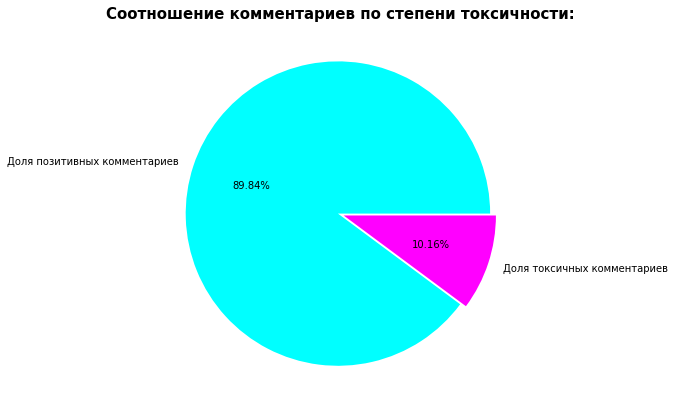

In [8]:
# Посчитаем и визуализируем доли комментариев обоих типов

comment_part = [len(data_comments.loc[data_comments['toxic']==0]),
                len(data_comments.loc[data_comments['toxic']==1])
               ]
print('Количество комментариев различных типов:', comment_part)

labels = ['Доля позитивных комментариев', 'Доля токсичных комментариев']
explode = [0.02, 0.02]

plt.figure(figsize=(7,7))
plt.pie(comment_part,
        labels=labels,
        explode=explode,
        colors=['cyan', 'magenta'],
        autopct='%.2f%%',
       )
plt.title('Соотношение комментариев по степени токсичности:',
          fontsize=15,
          fontweight="bold"
         )
plt.show()

In [9]:
# Очистим данные от разделителей строки, заглавных символов

def cleaning(text):
    text = re.sub(r"(?:\n|\r)", " ", text)
    text = re.sub(r"[^a-zA-Z` ]+", "", text).strip()
    text = text.lower()
    return text

data_comments['text'] = data_comments['text'].apply(cleaning)
data_comments.head()

,text,toxic
0,explanation why the edits made under my userna...,0
1,daww he matches this background colour im seem...,0
2,hey man im really not trying to edit war its j...,0
3,more i cant make any real suggestions on impro...,0
4,you sir are my hero any chance you remember wh...,0


In [10]:
# Преобразуем теги POS из пакета averaged_perceptron_tagger в теги WordNet

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return 'a'  # прилагательное
    elif treebank_tag.startswith('V'):
        return 'v'  # глагол
    elif treebank_tag.startswith('N'):
        return 'n'  # существительное
    elif treebank_tag.startswith('R'):
        return 'r'  # наречие
    else:
        return 'n'  # по умолчанию возвращаем существительное

In [11]:
# Проведем лемматизацию

lemmatizer = WordNetLemmatizer()
punctuation = set(string.punctuation)
stop_words = set(stopwords.words('english'))

def tokenization(text):
    tokenized = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokenized)
    filtered_words = [word for word, tag in pos_tags if word not in stop_words and word not in punctuation]
    filtered_tags = [tag for word, tag in pos_tags if word not in stop_words and word not in punctuation]
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in zip(filtered_words, filtered_tags)]
    text = ' '.join(lemmatized_words)
    return text

In [12]:
data_comments['tokenized'] = data_comments['text'].apply(tokenization)
data_comments.head()

,text,toxic,tokenized
0,explanation why the edits made under my userna...,0,explanation edits make username hardcore metal...
1,daww he matches this background colour im seem...,0,daww match background colour im seemingly stic...
2,hey man im really not trying to edit war its j...,0,hey man im really try edit war guy constantly ...
3,more i cant make any real suggestions on impro...,0,cant make real suggestion improvement wonder s...
4,you sir are my hero any chance you remember wh...,0,sir hero chance remember page thats


## Обучение моделей

In [ ]:
# Разделим данные на тренировочную и тестовую выборки

features = data_comments['text']
target = data_comments['toxic']

X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    test_size=0.2, 
                                                    random_state=42
                                                   )
print('Размерности выборок:', X_train.shape, X_test.shape, 'соответственно.')

In [14]:
def training(model, params):
    pipeline = Pipeline(
        [
        ('tfidf', TfidfVectorizer(min_df=1)),
        ('model', model)
        ]
    )
    grid = GridSearchCV(pipeline,
                        cv=3,
                        n_jobs=-1,
                        param_grid=params,
                        scoring='f1',
                        verbose=False
                       )
    grid.fit(X_train, y_train)
    print('Лучший результат:', grid.best_score_)
    print('Лучшие параметры:', grid.best_params_)
    return grid.best_score_, grid.best_estimator_

In [16]:
start_time = time.time()
lg_model_score, lg_model_estimator = training(LogisticRegression(random_state=42, max_iter=500),
                                              {"model__C": list(np.arange(10, 13, 1)),
                                               "model__penalty":['l2']
                                               }
                                              )
end_time = time.time()
lg_time = end_time - start_time
print(f"Время выполнения кода: {lg_time:.2f} сек.")

Лучший результат: 0.7764625431990604
Лучшие параметры: {'model__C': 12, 'model__penalty': 'l2'}
Время выполнения кода: 1284.09 сек.


In [ ]:
start_time = time.time()
dtc_model_score, dtc_model_estimator = training(DecisionTreeClassifier(random_state=42),
                                                {'model__criterion': ['gini','entropy'],
                                                 'model__max_depth': list(np.arange(90, 110, 10))
                                                 }
                                                )
end_time = time.time()
dtc_time = end_time - start_time
print(f"Время выполнения кода: {dtc_time:.2f} сек.")

In [ ]:
start_time = time.time()
svc_model_score, svc_model_estimator = training(LinearSVC(random_state=42, max_iter=500),
                                                {'model__C' : list(np.arange(1, 1.5, 0.1)),
                                                 'model__penalty' : ['l1', 'l2']
                                                 }
                                                )
end_time = time.time()
svc_time = end_time - start_time
print(f"Время выполнения кода: {svc_time:.2f} сек.")

In [ ]:
# Создадим сводную таблицу

title = 'Значения метрики качества F1'
time = 'Время выполнения кода'

best_scores = {title: [lg_model_score,
                       dtc_model_score,
                       svc_model_score
                       ],
               time: [lg_time,
                      dtc_time,
                      svc_time
                     ]
                      }
index = ['LogisticRegression', 'DecisionTreeClassifier', 'LinearSVC']

scores_data = pd.DataFrame(data=best_scores, index=index)

display(scores_data.sort_values(by=title, ascending=False).style.background_gradient(cmap='Greens', axis=0))

In [ ]:
# Получим метрику f1 на тестовых данных

predict = svc_model_estimator.predict(X_test)
lg_model_f1 = f1_score(y_test, predict)
print('Показатель f1 на тестовой выборке:', round(lg_model_f1, 3))

## Выводы

**В результате работы над проектом были проделаны следующие шаги:**

* загружены данные комментариев пользователей интернет-магазина «Викишоп» с оценкой токсичности твитов;
* произведены предобработка и анализ данных;  
* проведена очистка данных от разделителей строки, заглавных символов;
* проведена лемматизация текстов;
* произведено разделение данных на тренировочную, валидационную и тестовую выборки;
* проведена Tf-Idf векторизацию при помощи `TfidfVectorizer`;
* проведено обучение трех моделей (`LogisticRegression`, `DecisionTreeClassifier`, `LinearSVC`) с подбором гиперпараметров.

Наилучшее значение метрики `f1` = 0.793 на тренировочных данных показала `LinearSVC` с коэффициентом регуляризации `С` = 1.2.  
С незначительным отставанием следует `LogisticRegression` (`f1` = 0.779), она затратила наименьшее количество времени.
`DecisionTreeClassifier` справилась с задачей хуже всего - считала в 3-5 раз дольше линейных моделей,  
отставание по точности составило около 10% (`f1` = 0.7).

Значение `f1` на тестовой выборке модели `LinearSVC` составило 0.796, что удовлетворяет условию задания (`f1` >= 0.75).